# 梯度提升決策樹分類(Gradient Boost Decision TreeClassifier)

##### 先引入我們需要的packages`

In [1]:
import os 
import numpy as np
import random
import matplotlib.pyplot as plt
from random import choices

# Training Data

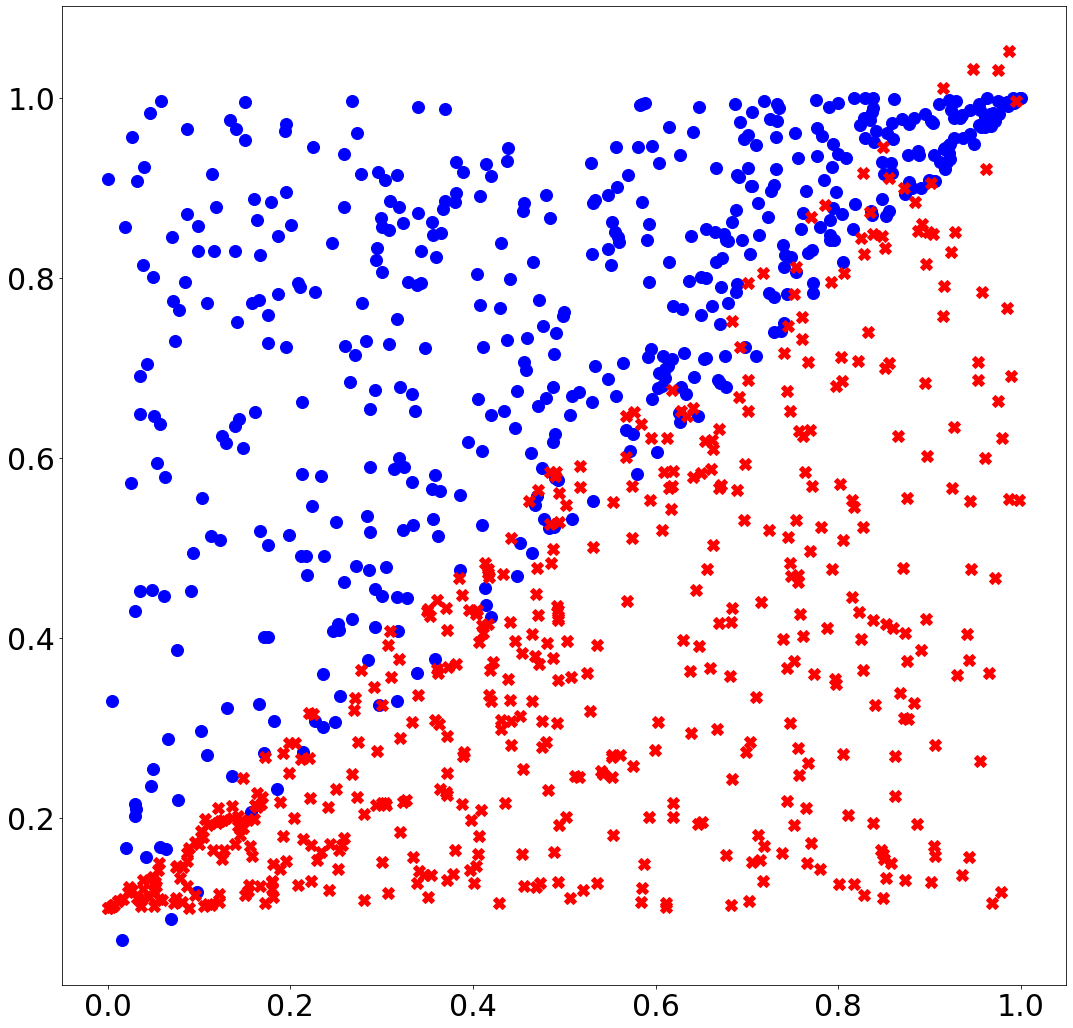

In [2]:
N=1000
x=np.zeros((N,2))
y=np.zeros(N)
for i in range(0,N): 
    f=-0.1
    if(i<N/2):
        y[i]=1
        x[i,0]=random.random()
        x[i,1]=random.uniform(x[i,0],1)
    else:
        y[i]=-1
        x[i,0]=random.random()
        x[i,1]=random.uniform(0,x[i,0])-f
plt.rcParams["figure.figsize"] = (18,18)
plt.plot(x[:500,0],x[:500,1],"bo",markersize=12)
plt.plot(x[500:,0],x[500:,1],"rX",markersize=12)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

# Testing Data

In [3]:
N_test=50
x_test=np.zeros((N_test,2))
y_test=np.zeros(N_test)
for i in range(0,N_test): 
    f=-0.1
    if(i<N_test/2):
        y_test[i]=1
        x_test[i,0]=random.random()
        x_test[i,1]=random.uniform(x_test[i,0],1)
    else:
        y_test[i]=-1
        x_test[i,0]=random.random()
        x_test[i,1]=random.uniform(0,x_test[i,0])-f

# Gini Index

In [4]:
def Gini(s,y):
    """
    這個方程式對應到Gini_index
    s:subtree裡面所有的index
    K:種類樹木
    """
    return 1-((sum(y[s]==1)/len(s))**2+(sum(y[s]==-1)/len(s))**2)

# Decision Stump

In [5]:
def Decision_Stump(x,y):
    """
    impurity_x0: 用來放橫軸特徵的impurity候選值
    impurity_x1: 用來放縱軸特徵的impurity候選值
    x0_sort: 所有資料點橫軸座標排序
    x1_sort: 所有資料點縱軸座標排序
    x0_sort_index:所有資料點橫軸座標排序後所對應的index
    x1_sort_index:所有資料點縱軸座標排序後所對應的index
    """
    impurity_x0=np.zeros(len(y)-1)
    impurity_x1=np.zeros(len(y)-1)
    
    x0_sort=np.sort(x[:,0])
    x1_sort=np.sort(x[:,1])
    
    x0_sort_index=np.argsort(x[:,0])
    x1_sort_index=np.argsort(x[:,1])
    """
    這裡的演算法核心就是我們以排列好的橫軸和縱標
    從第一個資料開始分成兩半，然後並計算impurity值
    -->迴圈執行步驟
    1. 以橫軸的feature分成兩個subtree
    2. 計算對應的橫軸impirity值
    3. 以縱軸的feature分成兩個subtree
    4. 計算對應的縱軸impirity值
    """
    for i in range(1,len(y)):
        s_left,s_right=x0_sort_index[:i],x0_sort_index[i:]
        impurity_x0[i-1]=(len(s_left)/len(y))*Gini(s_left,y)+(len(s_right)/len(y))*Gini(s_right,y)
        s_left,s_right=x1_sort_index[:i],x1_sort_index[i:]
        impurity_x1[i-1]=(len(s_left)/len(y))*Gini(s_left,y)+(len(s_right)/len(y))*Gini(s_right,y)
    """
    比較橫軸和縱軸最小的impurity值，如果其中一個比較小就回傳切割線座標
    """
    if(min(impurity_x0)<min(impurity_x1)):
        x_split=(x0_sort[np.argmin(impurity_x0)]+x0_sort[np.argmin(impurity_x0)+1])/2
        return x_split,0,min(impurity_x0)
    else:
        x_split=(x1_sort[np.argmin(impurity_x1)]+x1_sort[np.argmin(impurity_x1)+1])/2
        return x_split,1,min(impurity_x1)

# Decision Tree Algorithms

In [6]:
def Decision_Tree(x,y,x_real,y_real,x_test,y_test,index,index_test,max_depth,y_train,y_pred):
    """
    x: 輸入訓練資料(會隨遞迴深度改變數量)
    y: 輸出訓練資料(會隨遞迴深度改變數量)
    x_real: 輸入訓練資料(真實數據)
    y_real: 輸出訓練資料(真實數據)
    x_test: 輸入測試資料
    y_test: 輸出測試資料
    index: 當前輸入到決策樹演算法中的訓練資料編號
    index_test: 當前輸入到決策樹演算法中的測試資料編號
    max_depth: 最大決策樹深度
    x_lim: 用來畫分割區域的座標
    K: 輸出資料的類別數目
    y_train: 於訓練集所預測的輸出值
    y_pred: 於測試集所預測的輸出值
    """
    """
    執行Decision Stump演算法算出最佳分割線
    得到第m特徵的分割線座標x_split後
    以x_split和m將訓練Decision Tree的訓練資料(隨機選取的)分成left和right兩部分
    """
    x_split,m,impurity=Decision_Stump(x,y)
    p=x[:,m]<x_split
    x_left,y_left=x[p],y[p]
    x_right,y_right=x[~p],y[~p]
    """
    接著我們一樣以x_split和m，拆分我們的真實訓練資料和測試資料，所以這裡
    left_index和right_index分別代表在此Node的之下
    真實訓練資料分到左邊subtree的index和分到右邊subtree的index
    left_index_test和right_index_test分別代表在此Node的之下
    測試資料分到左邊subtree的index和分到右邊subtree的index
    """
    p_real=(x_real[:,m]<x_split).flatten()
    p_real_left=np.where(p_real)
    p_real_right=np.where(~p_real)
    left_index=np.intersect1d(p_real_left,index)
    right_index=np.intersect1d(p_real_right,index)
    p_test=(x_test[:,m]<x_split).flatten()
    p_test_left=np.where(p_test)
    p_test_right=np.where(~p_test)
    left_index_test=np.intersect1d(p_test_left,index_test)
    right_index_test=np.intersect1d(p_test_right,index_test)
    """
    檢查我們左邊和右邊的subtree
    他們是否已經分類完成，底下的類別全部相同。所以如果
    左邊的subtree分類完成check_left=True
    右邊的subtree分類完成check_right=True
    """
    check_left=True
    for i in range(0,len(y_left)):
        if(y_left[0]!=y_left[i]):
            check_left=False
            break
    check_right=True
    for i in range(0,len(y_right)):
        if(y_right[0]!=y_right[i]):
            check_right=False
            break
    """
    最後就是設定Decision Tree的停止條件
    1. impirity=0 / 2. 達到最大深度 / 3.左右兩邊subtree都完美分類好
    而這裡我們可以分成四個case
    (1) 達到Decision Tree停止條件
       --> 我們檢查左右兩邊Decision tree把他分成什麼類別後
           我們就將y_train和y_pred標註Decision Tree預測的類別，最後並回傳
    (2) 左邊的subtree分類完成，但是右邊的subtree還沒分好
       --> 我們檢查左邊的subtree的類別
           然後將左邊subtree的y_train和y_pred，標註Decision Tree所預測的類別
           接著將右邊subtree的資料帶入Decision Tree演算法繼續分類，最後並回傳
    (3) 右邊的subtree分類完成，但是左邊的subtree還沒分好
       --> 我們檢查右邊的subtree的類別
           然後將右邊subtree的y_train和y_pred，標註Decision Tree所預測的類別
           接著將左邊subtree的資料帶入Decision Tree演算法繼續分類，最後並回傳
    (4) 左右兩邊都沒有分好
       --> 將左邊和右邊的subtree都丟到Decision Tree演算法繼續分類，最後並回傳
    """
    if((impurity==0)or(max_depth==1)or((check_left)and(check_right))):
        if(sum(y_left==1)/len(y_left)>sum(y_right==1)/len(y_right)):
            label_left,label_right=1,-1
        elif(sum(y_left==1)/len(y_left)<sum(y_right==1)/len(y_right)):
            label_left,label_right=-1,1
        else:
            if(sum(y_left==-1)/len(y_left)>sum(y_right==-1)/len(y_right)):
                label_left,label_right=-1,1
            else:
                label_left,label_right=1,-1
        y_train[left_index],y_train[right_index]=label_left,label_right
        y_pred[left_index_test],y_pred[right_index_test]=label_left,label_right
        return y_train,y_pred
    elif(check_left):
        max_depth-=1
        y_train[left_index]=y_left[0]
        y_pred[left_index_test]=y_left[0]
        y_train,y_pred=Decision_Tree(x_right,y_right,x_real,y_real,x_test,y_test,
                                     right_index,right_index_test,max_depth,y_train,y_pred)
        return y_train,y_pred
    elif(check_right):
        max_depth-=1
        y_train[right_index]=y_right[0]
        y_pred[right_index_test]=y_right[0]
        y_train,y_pred=Decision_Tree(x_left,y_left,x_real,y_real,x_test,y_test,
                                     left_index,left_index_test,max_depth,y_train,y_pred)
        return y_train,y_pred
    else:
        max_depth-=1
        y_train,y_pred=Decision_Tree(x_left,y_left,x_real,y_real,x_test,y_test,
                                     left_index,left_index_test,max_depth,y_train,y_pred)
        y_train,y_pred=Decision_Tree(x_right,y_right,x_real,y_real,x_test,y_test,
                                     right_index,right_index_test,max_depth,y_train,y_pred)
        return y_train,y_pred

# Decision Stump for Gradient Boosting

In [7]:
def GB_Decision_Stump(x,y):
    """
    comp_x0: 用來放橫軸特徵的MSE候選值
    comp_x1: 用來放縱軸特徵的MSE候選值
    x0_sort: 所有資料點橫軸座標排序
    x1_sort: 所有資料點縱軸座標排序
    x0_sort_index:所有資料點橫軸座標排序後所對應的index
    x1_sort_index:所有資料點縱軸座標排序後所對應的index
    """
    comp_x0=np.zeros(len(y)-1)
    comp_x1=np.zeros(len(y)-1)
    x0_sort=np.sort(x[:,0])
    x1_sort=np.sort(x[:,1])
    x0_sort_index=np.argsort(x[:,0])
    x1_sort_index=np.argsort(x[:,1])
    for i in range(1,len(y)):
        s_left,s_right=x0_sort_index[:i],x0_sort_index[i:]
        left_temp=(len(s_left)/len(y))*sum((y[s_left]-np.mean(y[s_left]))**2)
        right_temp=(len(s_right)/len(y))*sum((y[s_right]-np.mean(y[s_right]))**2)
        comp_x0[i-1]=left_temp+right_temp
        s_left,s_right=x1_sort_index[:i],x1_sort_index[i:]
        left_temp=(len(s_left)/len(y))*sum((y[s_left]-np.mean(y[s_left]))**2)
        right_temp=(len(s_right)/len(y))*sum((y[s_right]-np.mean(y[s_right]))**2)
        comp_x1[i-1]=left_temp+right_temp
    """
    比較橫軸和縱軸最小的MSE值，如果其中一個比較小就回傳切割線座標
    """
    if(min(comp_x0)<min(comp_x1)):
        x_split=(x0_sort[np.argmin(comp_x0)]+x0_sort[np.argmin(comp_x0)+1])/2
        return x_split,0,min(comp_x0)
    else:
        x_split=(x1_sort[np.argmin(comp_x1)]+x1_sort[np.argmin(comp_x1)+1])/2
        return x_split,1,min(comp_x1)

# Decision Tree Algorithms for Gradient Boosting

In [8]:
def GB_Decision_Tree(x,r,x_real,x_test,index,index_test,max_depth,res,res_test):
    """
    x: 輸入訓練資料(會隨遞迴深度改變數量)
    r: 輸出訓練資料(會隨遞迴深度改變數量)
    x_real: 輸入訓練資料
    x_test: 輸入測試資料
    index: 當前輸入到決策樹演算法中的訓練資料編號
    index_test: 當前輸入到決策樹演算法中的測試資料編號
    max_depth: 最大決策樹深度
    res: 用來畫分割區域的座標
    res_test: 於訓練集所預測的輸出值
    """
    """
    執行Decision Stump演算法算出最佳分割線
    得到第m特徵的分割線座標x_split後
    以x_split和m將訓練Decision Tree的訓練資料(隨機選取的)分成left和right兩部分
    """
    x_split,m,impurity=GB_Decision_Stump(x,r)
    p=x[:,m]<x_split
    x_left,r_left=x[p,:],r[p]
    x_right,r_right=x[~p],r[~p]
    """
    接著我們一樣以x_split，拆分我們的真實訓練資料和測試資料，所以這裡
    left_index和right_index分別代表在此Node的之下
    真實訓練資料分到左邊subtree的index和分到右邊subtree的index
    left_index_test和right_index_test分別代表在此Node的之下
    測試資料分到左邊subtree的index和分到右邊subtree的index
    """
    p_real=x_real[:,m]<x_split
    p_real_left=np.where(p_real)
    p_real_right=np.where(~p_real)
    left_index=np.intersect1d(p_real_left,index)
    right_index=np.intersect1d(p_real_right,index)
    p_test=x_test[:,m]<x_split
    p_test_left=np.where(p_test)
    p_test_right=np.where(~p_test)
    left_index_test=np.intersect1d(p_test_left,index_test)
    right_index_test=np.intersect1d(p_test_right,index_test)
    """
    檢查左右兩邊的subtree是否只剩下一筆或是輸出資料r都相同
    """
    check_left,check_right=True,True
    if(len(r_left)!=1):
        for i in range(1,len(r_left)):
            if(r_left[i]!=r_left[0]):
                check_left=False
                break
    if(len(r_right)!=1):
        for i in range(1,len(r_right)):
            if(r_right[i]!=r_right[0]):
                check_right=False
                break
    """
    <Condiction>
    (sel==0)
    -->代表當前Node底下的兩個subtree都完美回歸MSE=0，或是已達到所限制的最大層數
       所以我們畫出左右兩邊的橫回歸線和中間的縱回歸線
    (sel==1)
    -->代表當前Node底下的兩個subtree都還沒分完
       所以我們只畫出中間的縱回歸線
    (sel==2)
    -->代表當前Node底下，右邊的subtree已完美回歸MSE=0，但是左邊的subtree還沒分完
       所以我們只畫出右邊的橫回歸線
    (sel==3)
    -->代表當前Node底下，左邊的subtree已完美回歸MSE=0，但是右邊的subtree還沒分完
       所以我們只畫出右邊的橫回歸線
    """
    if((impurity==0)or(max_depth==0)or((check_left)and(check_right))):
        gamma_left=sum(r_left)/sum(abs(r_left)/(2-abs(r_left)))
        gamma_right=sum(r_right)/sum(abs(r_right)/(2-abs(r_right)))
        res[left_index],res[right_index]=gamma_left,gamma_right
        res_test[left_index_test],res_test[right_index_test]=gamma_left,gamma_right
        return res,res_test
    elif(check_left):
        max_depth-=1
        res,res_test=GB_Decision_Tree(x_right,r_right,x_real,x_test,right_index,right_index_test,
                                   max_depth,res,res_test)
        gamma_left=sum(r_left)/sum(abs(r_left)/(2-abs(r_left)))
        res[left_index]=gamma_left
        res_test[left_index_test]=gamma_left
        return res,res_test
    elif(check_right):
        max_depth-=1
        res,res_test=GB_Decision_Tree(x_left,r_left,x_real,x_test,left_index,left_index_test,
                                   max_depth,res,res_test)
        gamma_right=sum(r_right)/sum(abs(r_right)/(2-abs(r_right)))
        res[right_index]=gamma_right
        res_test[right_index_test]=gamma_right
        return res,res_test
    else:
        max_depth-=1
        res,res_test=GB_Decision_Tree(x_left,r_left,x_real,x_test,left_index,left_index_test,
                                   max_depth,res,res_test)
        res,res_test=GB_Decision_Tree(x_right,r_right,x_real,x_test,right_index,right_index_test,
                                   max_depth,res,res_test)
        return res,res_test

# Gradient Boost

In [9]:
"""
Decision Tree
"""
y_train_DT=np.zeros(len(y))
y_pred_DT=np.zeros(len(y_test))
depth=5
y_train_DT,y_pred_DT=Decision_Tree(x,y,x,y,x_test,y_test,np.where(y),np.where(y_test),
                                   depth,y_train_DT,y_pred_DT)

In [10]:
"""
Gradient Boosted Decision Tree
"""
"""
初始化我們的方程式F
T: 迴圈數
depth: 決策樹深度
"""
F=np.ones(N)*(1/2)*np.log((1+np.mean(y))/(1-np.mean(y)))
F_test=np.zeros(N_test)+F[0]
T=12
depth=5
"""
1. 計算殘差值
2. 宣告res存放訓練集的每筆數據的gamma值
3. 宣告res_test存放測試集的每筆數據的gamma值
4. 訓練decision tree regressor
5. 將res加上F
6. 將res_test加上F_test
"""
for i in range(0,T):
    r=2*y/(1+np.exp(2*y*F))
    res=np.zeros(N)
    res_test=np.zeros(N_test)
    res,res_test=GB_Decision_Tree(x,r,x,x_test,np.where(y),np.where(y_test),depth,res,res_test)
    F+=res
    F_test+=res_test
"""
計算訓練集和測試集的預測值
"""
y_train_GBDT=np.zeros(N)
y_pred_GBDT=np.zeros(N_test)
p_pos=(1/(1+np.exp(-2*F)))
p_neg=(1/(1+np.exp(2*F)))
p_pos_test=(1/(1+np.exp(-2*F_test)))
p_neg_test=(1/(1+np.exp(2*F_test)))
BOOL=p_pos>p_neg
BOOL_test=p_pos_test>p_neg_test
y_train_GBDT[BOOL]=1
y_train_GBDT[~BOOL]=-1
y_pred_GBDT[BOOL_test]=1
y_pred_GBDT[~BOOL_test]=-1

# Result

In [11]:
print("------------------Decision Tree------------------")
print("The Decision Tree Training error rate:",sum(~(y_train_DT==y))/len(y),
      " / Testing error rate:",sum(~(y_pred_DT==y_test))/len(y_test))
print("------------------Gradient Boosted Decision Tree------------------")
print("The Gradient Boosted Decision Tree Training error rate:",sum(~(y_train_GBDT==y))/len(y),
      " / Testing error rate:",sum(~(y_pred_GBDT==y_test))/len(y_test))

------------------Decision Tree------------------
The Decision Tree Training error rate: 0.096  / Testing error rate: 0.16
------------------Gradient Boosted Decision Tree------------------
The Gradient Boosted Decision Tree Training error rate: 0.0  / Testing error rate: 0.12
